In [1]:
import glob
import os
import difflib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set(rc={'figure.figsize': (12.7, 8.27)})

# Southampton University Gliding Flight Logs Analysis
Author: <A.Pilko@soton.ac.uk>

# Load data
## Shalbourne Flight Logs

In [2]:
flights_df = pd.concat([pd.read_csv(path) for path in glob.glob("../data/flightlogs/*.csv")]).drop(labels=['No'],
                                                                                                   axis=1)

In [3]:
# Assign some types
flights_df['Date'] = pd.to_datetime(flights_df['Date'])
flights_df['Glider'] = flights_df['Glider'].astype(str)
flights_df['Takeoff'] = pd.to_datetime(flights_df['Takeoff'])
flights_df['FlightTime'] = pd.to_timedelta(flights_df['FlightTime'])
flights_df['Comment'] = flights_df['Comment'].astype(str)


# Replace takeoff date with actual date of flight
def replace_takeoff_date(row):
    row['Takeoff'] = row['Takeoff'].replace(year=row['Date'].year, month=row['Date'].month, day=row['Date'].day)
    return row


flights_df = flights_df.apply(replace_takeoff_date, axis=1)

/tmp/ipykernel_871545/931581169.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  flights_df['Takeoff'] = pd.to_datetime(flights_df['Takeoff'])


In [4]:
# Replace expected NaNs
flights_df['Comment'] = flights_df['Comment'].replace('nan', '')
flights_df['P2'] = flights_df['P2'].replace('nan', '').replace(np.nan, '')

# Break out takeoff time into hour and minute for less pain later
flights_df['TakeoffMinute'] = flights_df['Takeoff'].dt.minute
# Make decimal hours
flights_df['TakeoffHour'] = flights_df['Takeoff'].dt.hour + flights_df['TakeoffMinute'] / 60

# Get rid of anomalies
flights_df = flights_df[flights_df['TakeoffHour'] > 7]
flights_df = flights_df[flights_df['TakeoffHour'] < 20]


## SUGC Membership

In [5]:
sugc_members_df = pd.read_csv('../data/sugc_members.csv', usecols=['firstName', 'lastName', 'driver', 'committee']).dropna()
sugc_members_df['Name'] = sugc_members_df['firstName'] + ' ' + sugc_members_df['lastName']
sugc_members_df['SUGC'] = True

## Fuzzy match names
Log names are sometimes misspelt, so we need to fuzzy match them to the SUGC members list.

In [6]:
def fuzzy_match_name(row):
    key = 'P2' if row['P2'] != '' else 'P1'
    matches = difflib.get_close_matches(row[key], sugc_members_df['Name'], cutoff=0.70)
    row['SugcMember'] = matches[0] if matches else ''
    return row

flights_df = flights_df.apply(fuzzy_match_name, axis=1)

# Plots
## SUGC Only Plots

In [7]:
sugc_flights = flights_df[flights_df['SugcMember'] != '']

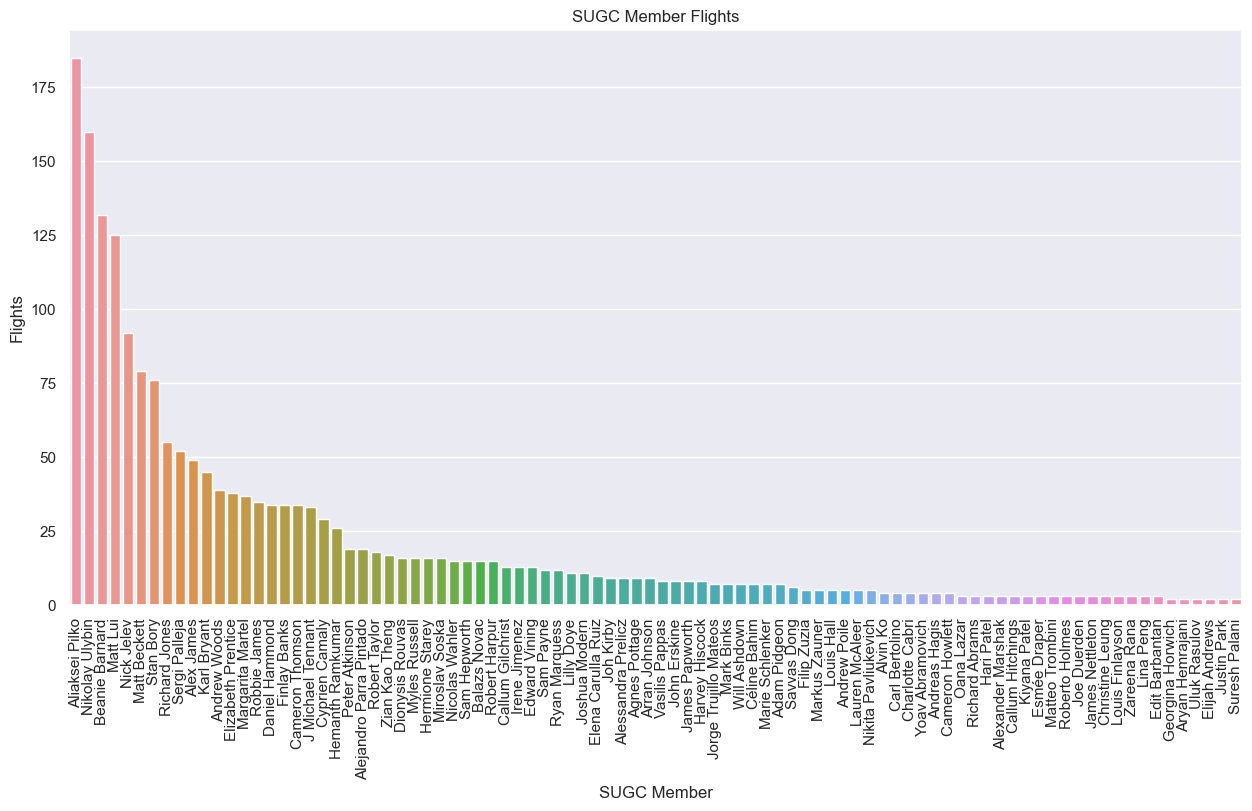

In [8]:
sns.barplot(x=sugc_flights['SugcMember'].value_counts()[:90].index, y=sugc_flights['SugcMember'].value_counts()[:90])
plt.xticks(rotation=90)
plt.xlabel('SUGC Member')
plt.ylabel('Flights')
plt.title('SUGC Member Flights')
plt.tight_layout()

## Combined Plots

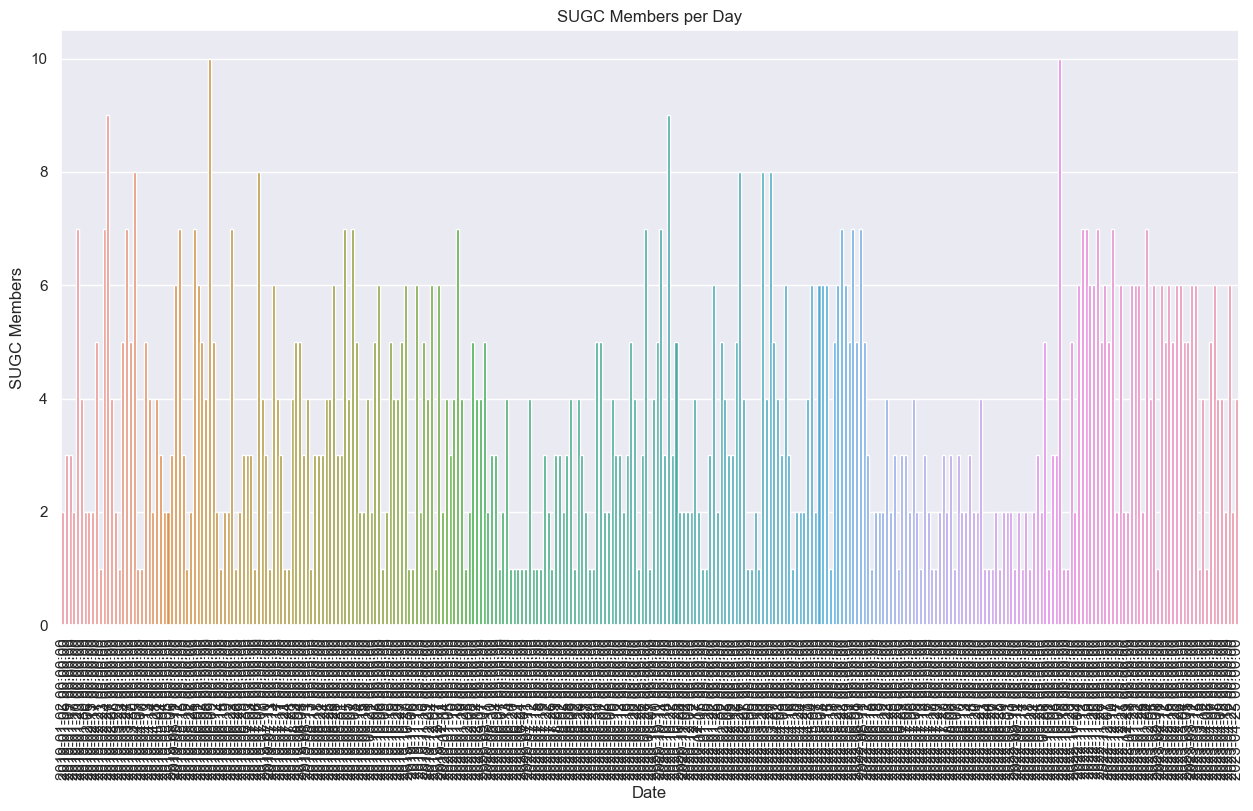

In [9]:
sugc_members_vs_days = flights_df.groupby('Date')['SugcMember'].nunique()
sns.barplot(x=sugc_members_vs_days.index, y=sugc_members_vs_days)
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('SUGC Members')
plt.title('SUGC Members per Day')
plt.tight_layout()

In [10]:
daily_sugc_count = flights_df.groupby('Date')['SugcMember'].unique()

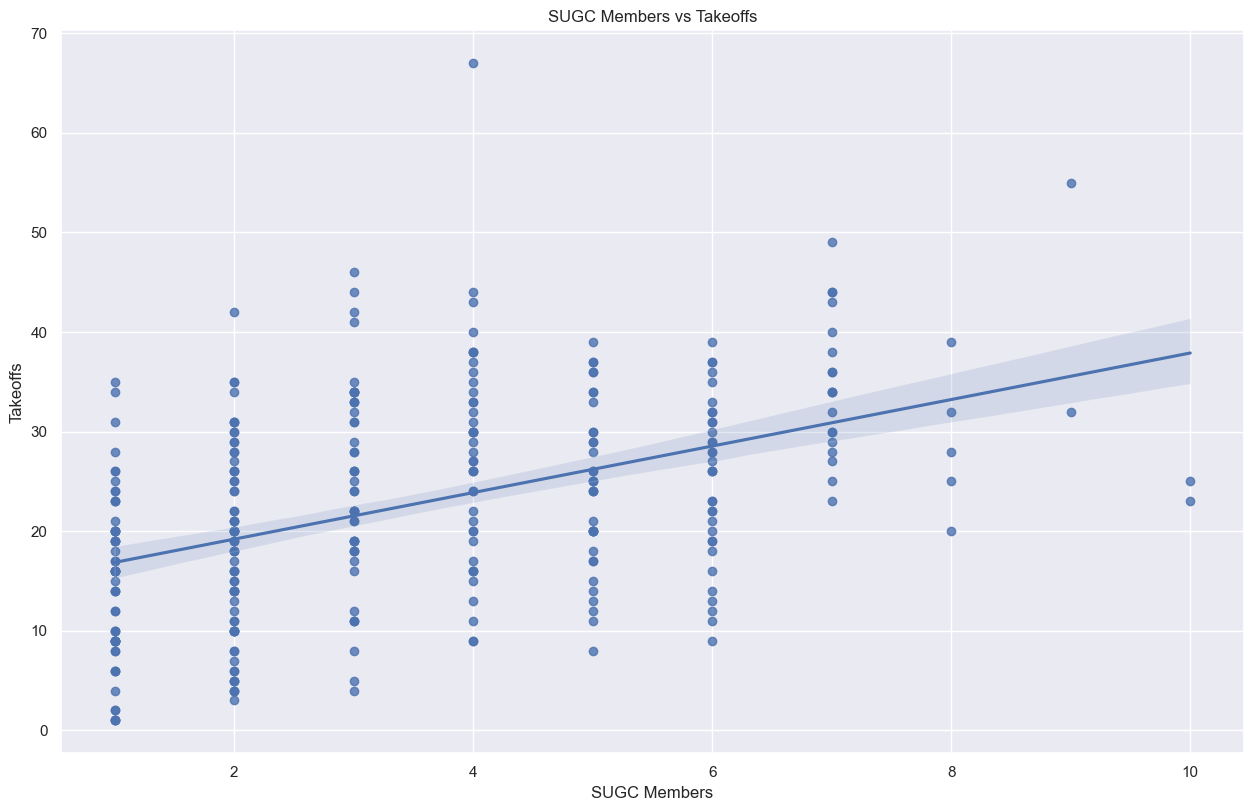

In [11]:
daily_sugc_count_vs_takeoff_count = pd.DataFrame({'SugcMembers': daily_sugc_count.apply(lambda x: len(x)),
                                                   'Takeoffs': flights_df.groupby('Date')['Takeoff'].count()})
sns.regplot(x=daily_sugc_count_vs_takeoff_count['SugcMembers'],
                y=daily_sugc_count_vs_takeoff_count['Takeoffs'])
plt.xlabel('SUGC Members')
plt.ylabel('Takeoffs')
plt.title('SUGC Members vs Takeoffs')
plt.tight_layout()

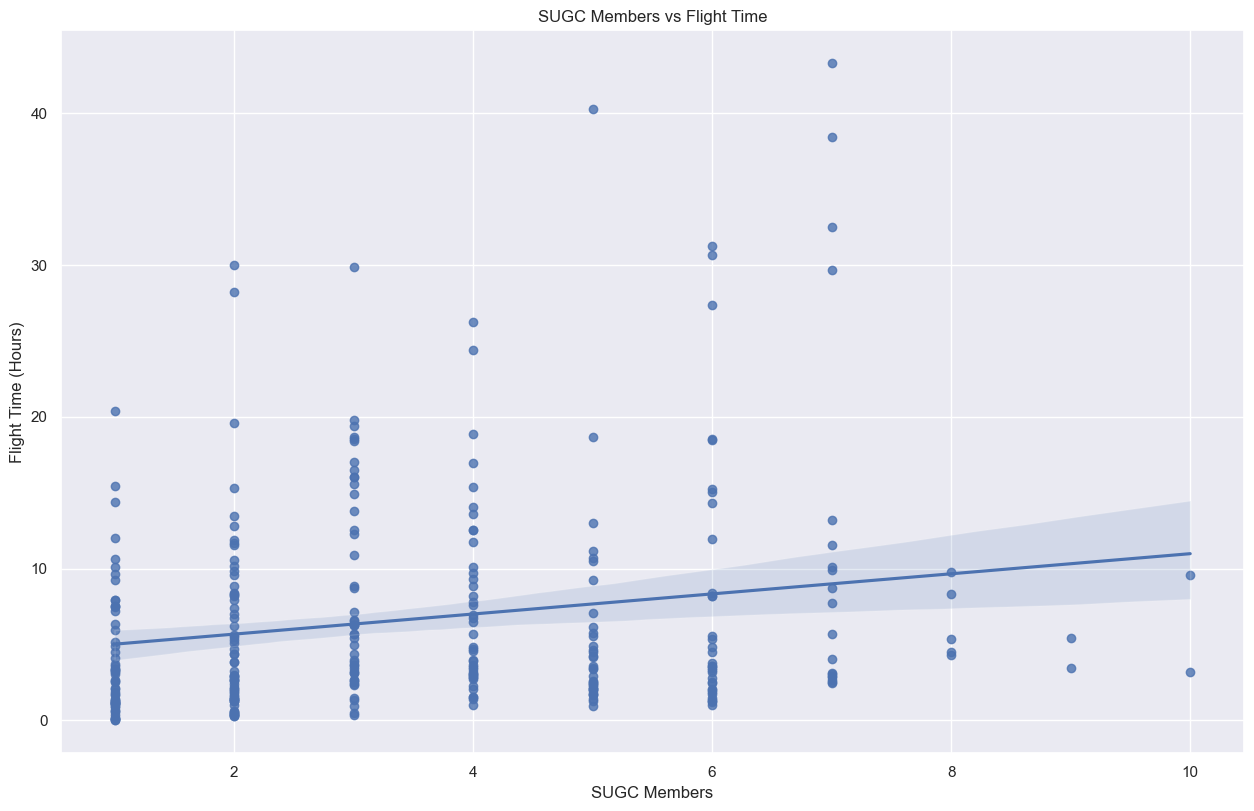

In [12]:
daily_sugc_count_vs_flight_time = pd.DataFrame({'SugcMembers': daily_sugc_count.apply(lambda x: len(x)),
                                                'FlightTime': flights_df.groupby('Date')['FlightTime'].sum()})
sns.regplot(x=daily_sugc_count_vs_flight_time['SugcMembers'],
            y=daily_sugc_count_vs_flight_time['FlightTime'].dt.total_seconds() / 3600)
plt.xlabel('SUGC Members')
plt.ylabel('Flight Time (Hours)')
plt.title('SUGC Members vs Flight Time')
plt.tight_layout()

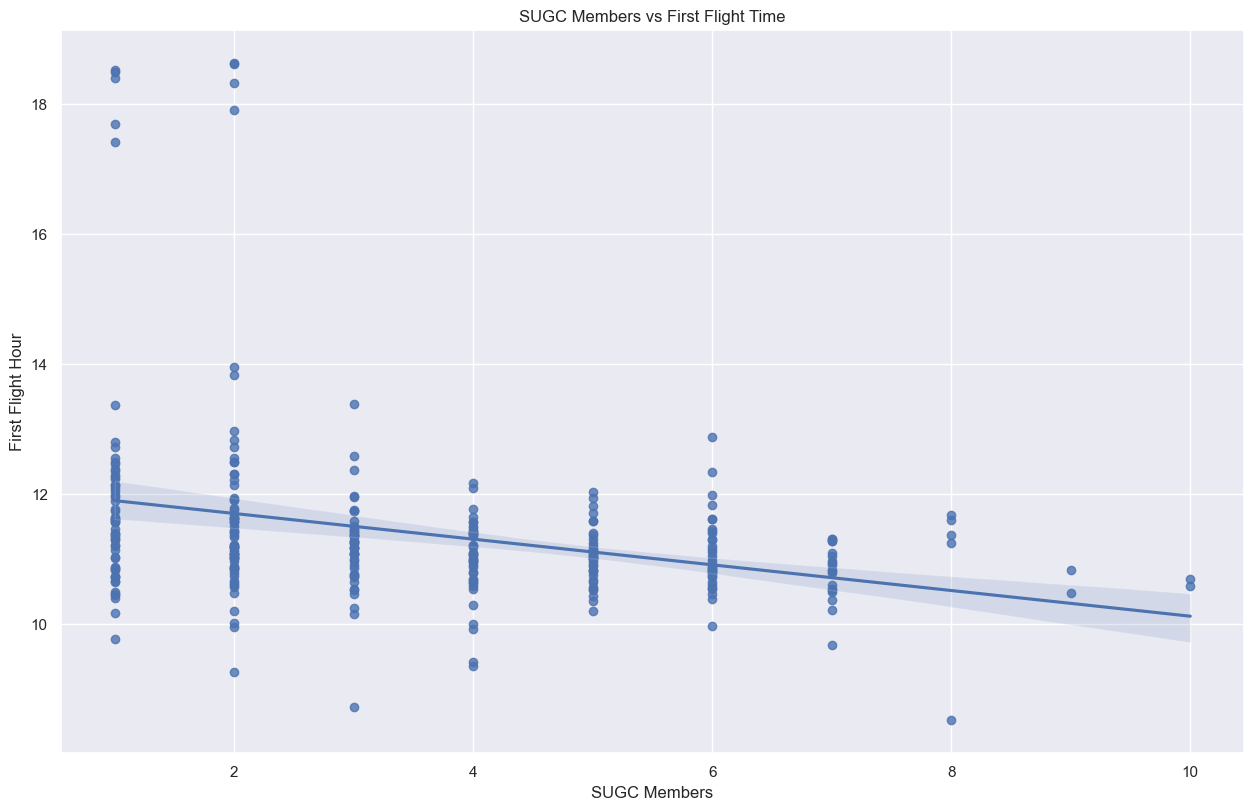

In [13]:
daily_sugc_count_vs_first_flight_time = pd.DataFrame({'SugcMembers': daily_sugc_count.apply(lambda x: len(x)),
                                                      'FirstFlightHour': flights_df.groupby('Date')['TakeoffHour'].min()})
sns.regplot(x=daily_sugc_count_vs_first_flight_time['SugcMembers'],
            y=daily_sugc_count_vs_first_flight_time['FirstFlightHour'])
plt.xlabel('SUGC Members')
plt.ylabel('First Flight Hour')
plt.title('SUGC Members vs First Flight Time')
plt.tight_layout()

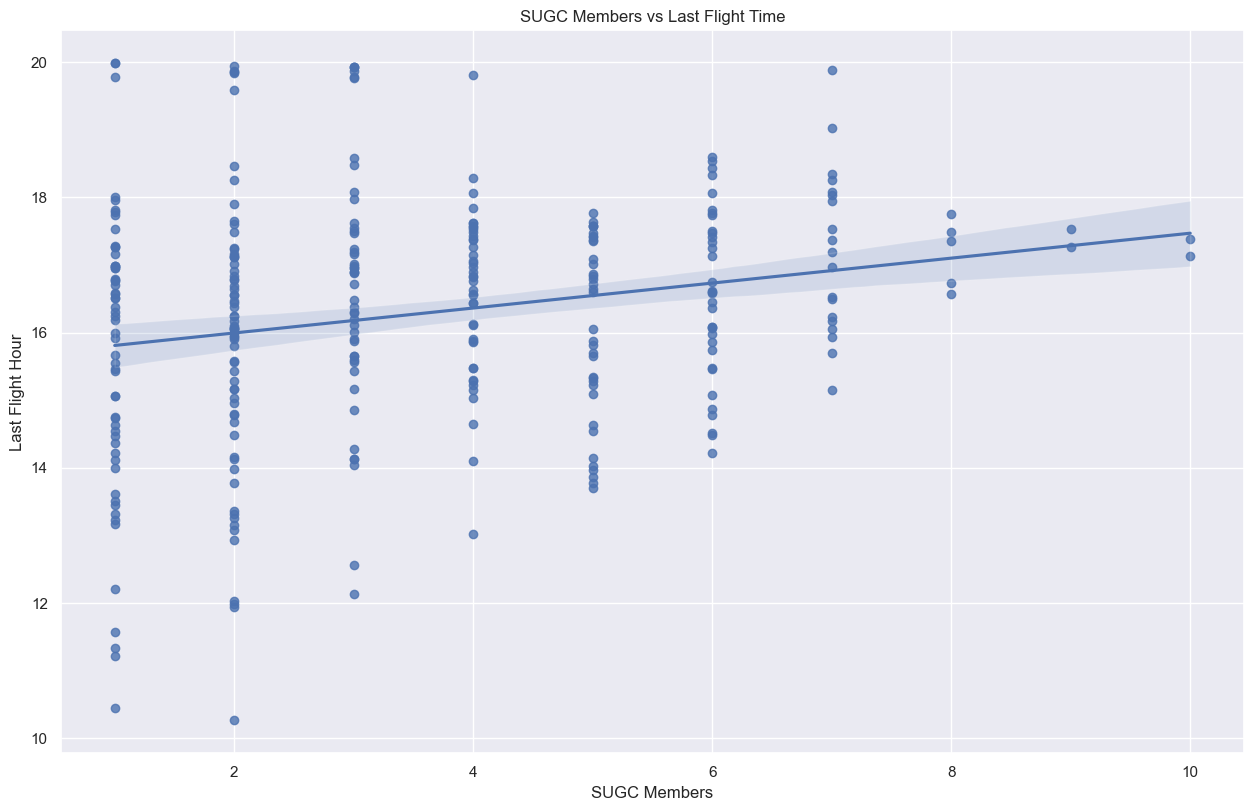

In [14]:
daily_sugc_count_vs_last_flight_time = pd.DataFrame({'SugcMembers': daily_sugc_count.apply(lambda x: len(x)),
                                                     'LastFlightHour': flights_df.groupby('Date')['TakeoffHour'].max()})
sns.regplot(x=daily_sugc_count_vs_last_flight_time['SugcMembers'],
            y=daily_sugc_count_vs_last_flight_time['LastFlightHour'])
plt.xlabel('SUGC Members')
plt.ylabel('Last Flight Hour')
plt.title('SUGC Members vs Last Flight Time')
plt.tight_layout()

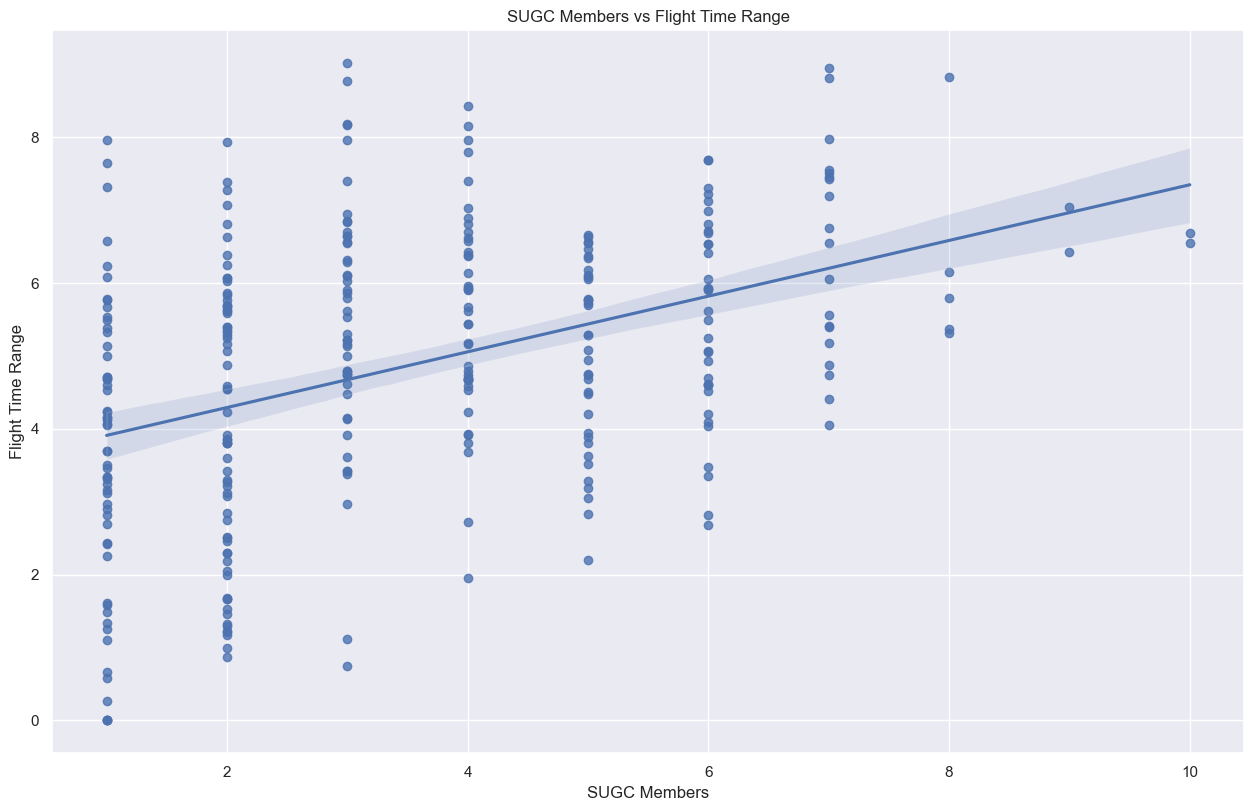

In [15]:
daily_sugc_count_vs_flight_time_range = pd.DataFrame({'SugcMembers': daily_sugc_count.apply(lambda x: len(x)),
                                                      'FlightTimeRange': flights_df.groupby('Date')['TakeoffHour'].max() - flights_df.groupby('Date')['TakeoffHour'].min()})
sns.regplot(x=daily_sugc_count_vs_flight_time_range['SugcMembers'],
            y=daily_sugc_count_vs_flight_time_range['FlightTimeRange'])
plt.xlabel('SUGC Members')
plt.ylabel('Flight Time Range')
plt.title('SUGC Members vs Flight Time Range')
plt.tight_layout()